In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

import seaborn as sns
from datetime import datetime
import calendar


In [2]:
sheet_name = 'Sheet1'
file_name = 'merged_dataset_updated.xlsx'
chs = pd.read_excel(file_name, sheet_name = sheet_name)
chs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19115 entries, 0 to 19114
Data columns (total 11 columns):
CP ID             19115 non-null int64
Total kWh         19115 non-null float64
StartDateTime     19115 non-null datetime64[ns]
EndDateTime       19115 non-null datetime64[ns]
User ID           19115 non-null object
Charging event    19115 non-null int64
Connector         19115 non-null int64
Type              19115 non-null object
Latitude          19115 non-null float64
Longitude         19115 non-null float64
Location Name     19115 non-null object
dtypes: datetime64[ns](2), float64(3), int64(3), object(3)
memory usage: 1.6+ MB


In [3]:
chs.head()

,CP ID,Total kWh,StartDateTime,EndDateTime,User ID,Charging event,Connector,Type,Latitude,Longitude,Location Name
0,51547,15.459,2018-01-07 02:34:00,2018-01-07 02:56:00,605338,7383721,2,Rapid,56.471876,-3.011184,Lochee Charging Hub
1,51547,15.093,2018-02-07 03:40:00,2018-02-07 04:07:00,605338,7385805,2,Rapid,56.471876,-3.011184,Lochee Charging Hub
2,51547,12.465,2018-03-08 01:20:00,2018-03-08 01:46:00,605338,7484504,2,Rapid,56.471876,-3.011184,Lochee Charging Hub
3,51547,11.690,2018-01-07 22:53:00,2018-01-07 23:10:00,605338,7385672,2,Rapid,56.471876,-3.011184,Lochee Charging Hub
4,51547,0.059,2018-01-07 18:09:00,2018-01-07 18:10:00,605338,7385279,2,Rapid,56.471876,-3.011184,Lochee Charging Hub


In [4]:
unique_CPID = chs['CP ID'].unique() # CPs that are actually used
num_CPID = unique_CPID.size

# save a copy of data
chs_original = chs.copy() 

## Data Analysis / Statistics 
> 
* Charging Sessions count - to show which site is the busiest
* Energy Consumption count

### Total charge sessions count by site

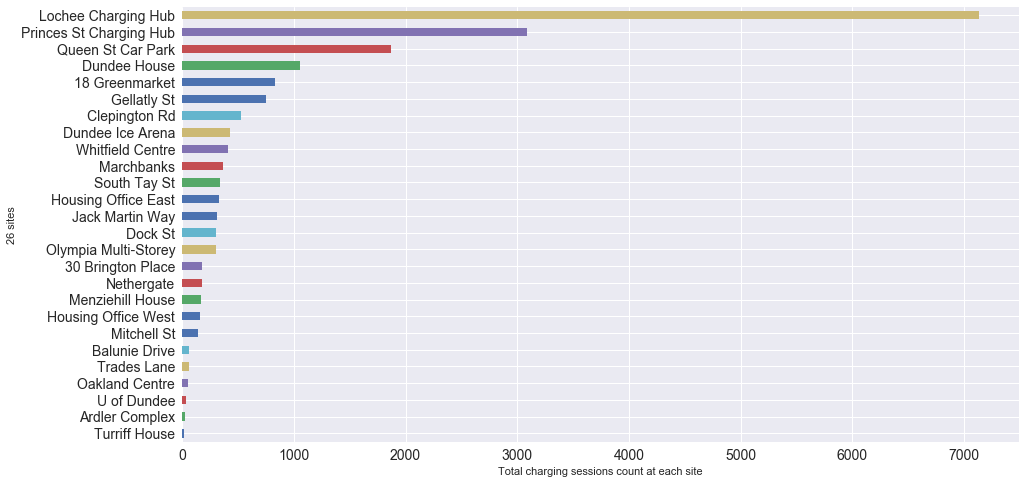

In [5]:
chs_by_site = chs.groupby('Location Name').size().sort_values()

# plot
num_of_site = chs_by_site.size
fig, ax = plt.subplots(figsize=(15,8))
ax = chs_by_site.plot(x='Location Name', kind='barh', fontsize=14)
ax.set_xlabel('Total charging sessions count at each site')
ax.set_ylabel('{} sites'.format(num_of_site))
fig.savefig('Total_sessions_by_site.png')

### Charge sessions trend over time

Text(0.5,1,'Total weekly energy consumptions [kWh]')

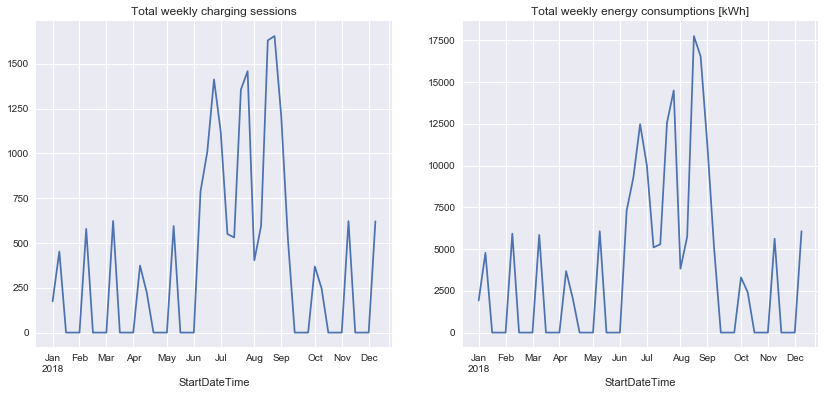

In [6]:
# set StartDateTime as index
chs = chs.set_index(chs.StartDateTime)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0] = chs['Charging event'].resample('W').size().plot(ax = ax[0])

ax[1] = chs['Total kWh'].resample('W').sum().plot(ax = ax[1])

ax[0].set_title('Total weekly charging sessions')
ax[1].set_title('Total weekly energy consumptions [kWh]')


### Hourly charge sessions count
> Sum over all types of charge points, all sites, and all day regardless weekday and weekend

In [7]:
# add more columns
chs['DayofWeek'] = chs.index.dayofweek
chs['DayofWeekName'] = chs.index.weekday_name
chs['StartHour'] = chs.index.hour
peak = chs.loc[(chs.index.month > 5) & (chs.index.month < 10)] # between June and September
off_peak = chs.loc[~((chs.index.month > 5) & (chs.index.month < 10))]


Text(0.5,1,'Hourly charge sessions count off-peak 2018')

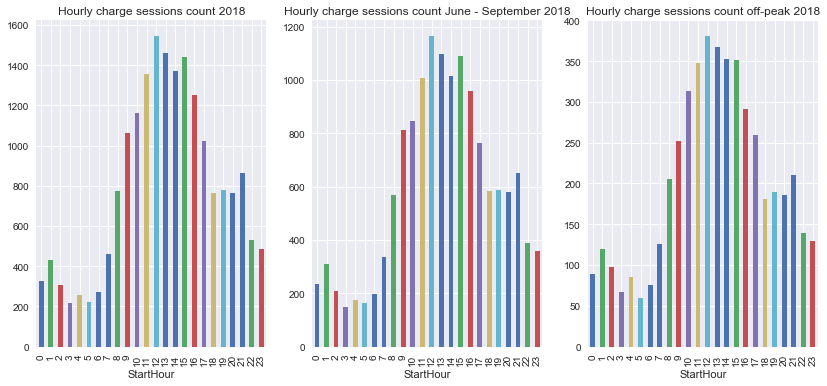

In [8]:
# plot
fig, ax = plt.subplots(1, 3, figsize=(14,6))
chs.groupby(['StartHour']).size().plot(kind='bar', ax = ax[0])
ax[0].set_title('Hourly charge sessions count 2018')

peak.groupby(['StartHour']).size().plot(kind='bar', ax = ax[1])
ax[1].set_title('Hourly charge sessions count June - September 2018')

off_peak.groupby(['StartHour']).size().plot(kind='bar', ax = ax[2])
ax[2].set_title('Hourly charge sessions count off-peak 2018')


### Are there patterns of busy hours?
> Does this vary by 
* Day of week
* Type of charge points

In [9]:
pivoted = chs.pivot_table(index=chs.StartHour, columns=chs.index.date, values=['Charging event'], aggfunc={'Charging event':len}, fill_value=0)
pivoted.iloc[:5, :5]

Charging event                                            
              2018-01-07 2018-01-08 2018-01-09 2018-02-07 2018-02-08
StartHour                                                           
0                      5          4          4          2          5
1                      9          4         12          2          3
2                      7          1         10          1          2
3                      5          1          6          5          0
4                      8          4          2          3          1

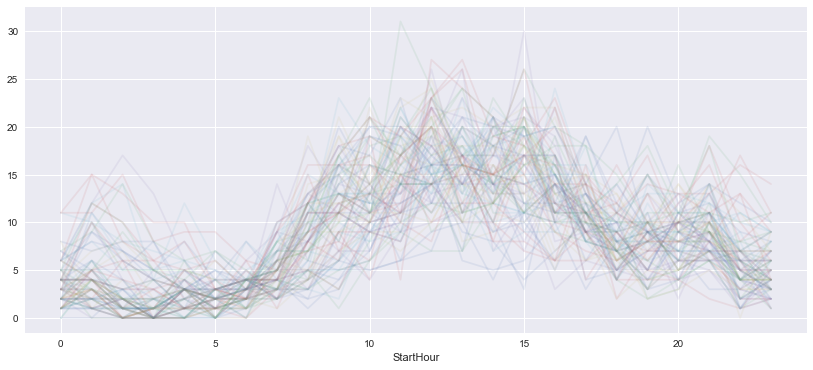

In [10]:
pivoted.plot(legend=False, alpha=0.1, figsize=(14,6))
# each line represents each day
# the value is number of charge events on each day at each hour

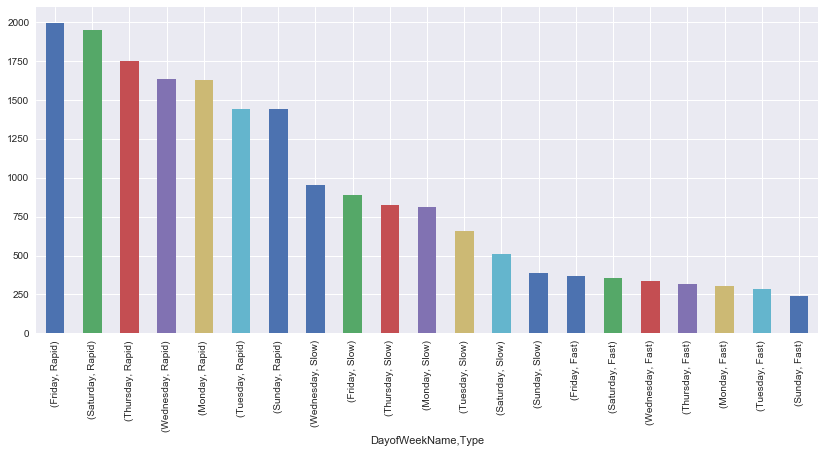

In [11]:
chs.groupby(['DayofWeekName', 'Type']).size().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

In [12]:
# number of charge sessions on slow, fast and rapid CPs
chs.groupby('Type').size()

Type
Fast      2217
Rapid    11850
Slow      5048
dtype: int64

In [13]:
# number of slow, fast and rapid CPs
chs.drop_duplicates(['CP ID']).groupby('Type').size()

Type
Fast     13
Rapid    15
Slow     35
dtype: int64

Text(0.5,1,'Total charge sessions at slow CPs')

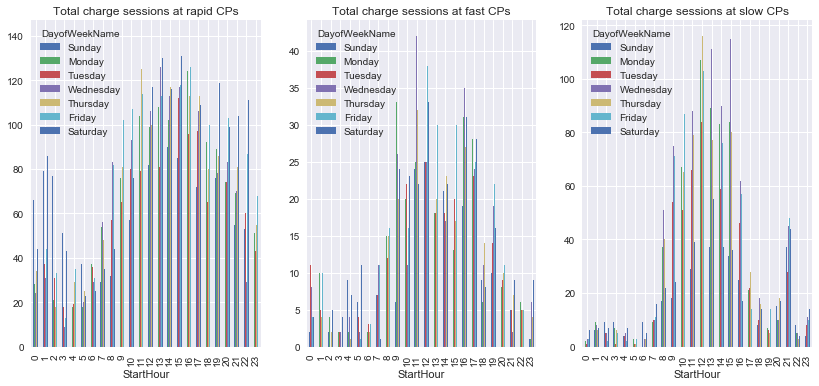

In [14]:
rapid = chs[chs['Type']=='Rapid']
fast = chs[chs['Type']=='Fast']
slow = chs[chs['Type']=='Slow']

#reshape the dataframe in a pivot table
pivoted_r = rapid.pivot_table(values='Charging event', 
                              index='StartHour', 
                              columns='DayofWeekName', 
                              aggfunc=len)
pivoted_r = pivoted_r[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
# pivoted_r.iloc[:5,:7]

pivoted_f = fast.pivot_table(values='Charging event',
                            index='StartHour',
                            columns='DayofWeekName',
                            aggfunc=len)
pivoted_f = pivoted_f[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]

pivoted_s = slow.pivot_table(values='Charging event',
                            index='StartHour',
                            columns='DayofWeekName',
                            aggfunc=len)
pivoted_s = pivoted_s[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]

# plot

fig, ax = plt.subplots(1, 3, figsize=(14,6))

ax[0] = pivoted_r.plot(kind='bar', ax = ax[0])
ax[0].set_title('Total charge sessions at rapid CPs')

ax[1] = pivoted_f.plot(kind='bar', ax = ax[1])
ax[1].set_title('Total charge sessions at fast CPs')

ax[2] = pivoted_s.plot(kind='bar', ax = ax[2])
ax[2].set_title('Total charge sessions at slow CPs')


Text(0.5,1,'Charge Sessions at slow CPs')

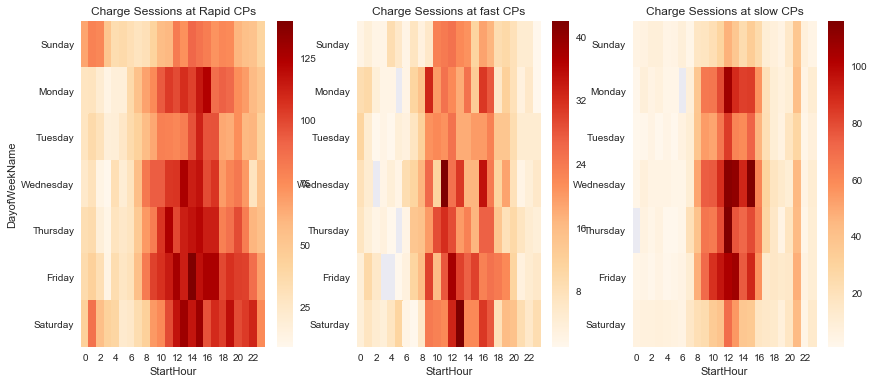

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))

ax[0] = sns.heatmap(pivoted_r.T, ax = ax[0], xticklabels=2, cmap='OrRd')
ax[0].set_title('Charge Sessions at Rapid CPs')

ax[1] = sns.heatmap(pivoted_f.T, ax = ax[1], xticklabels=2, cmap='OrRd')
ax[1].set_title('Charge Sessions at fast CPs')

ax[2] = sns.heatmap(pivoted_s.T, ax = ax[2], xticklabels=2, cmap='OrRd' )
ax[2].set_title("Charge Sessions at slow CPs")

### By total power consumption at each site
> If a session doesn't end correctly, there will be no power consumption recorded. Filter out those who have NaN power consumption values.

Text(0,0.5,'26 sites')

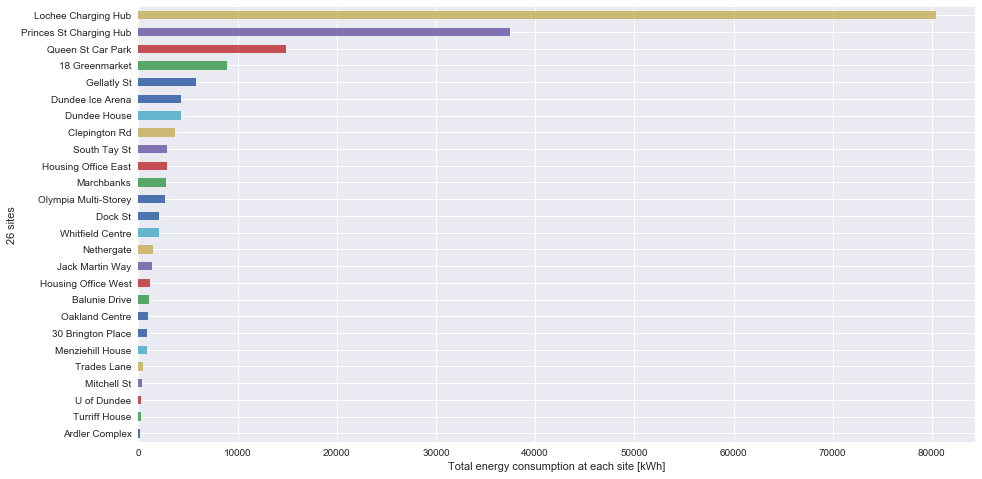

In [16]:
consump_by_site = chs[chs['Total kWh'].notnull()].groupby(['Location Name'])['Total kWh'].sum().sort_values()

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax = consump_by_site.plot(x='Location Name', y='Total kWh', kind='barh')

ax.set_xlabel('Total energy consumption at each site [kWh]')
ax.set_ylabel('{} sites'.format(num_of_site))
# fig.savefig('consump_at_site.png')

Text(0.5,1,'Total energy consumption [kWh]')

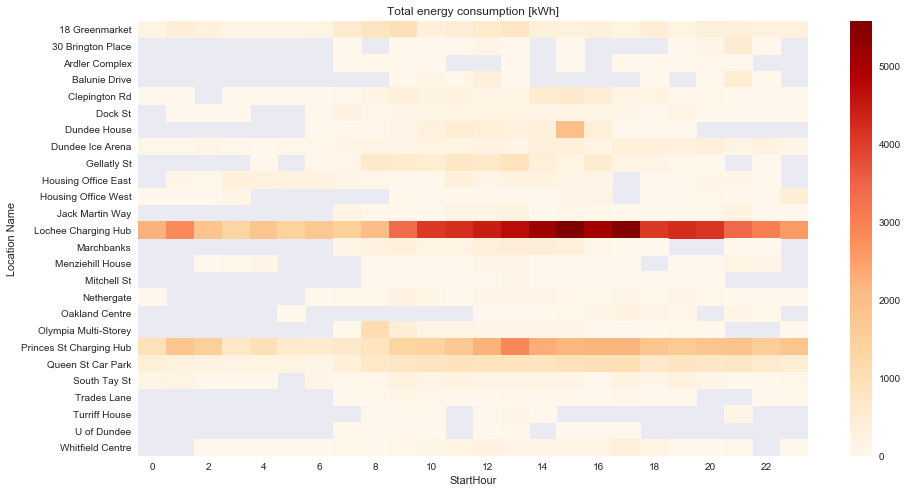

In [17]:
# total consumption per hour
consump = chs[chs['Total kWh'].notnull()].sort_index()

pivoted_consump = consump.pivot_table(index='Location Name',
                                      columns='StartHour',
                                      values='Total kWh',
                                      aggfunc=sum)

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax = sns.heatmap(pivoted_consump, xticklabels=2, cmap='OrRd')

ax.set_title("Total energy consumption [kWh]")
# plt.tight_layout()
# fig.savefig("ConsumptionHeatMap.png")

In [18]:
# consump['EndDateTime']-consump['StartDateTime'] -> negative values -> data need calibration
# slow:7kW fast:22kW rapid:50kW 
# calculate the acutal charging duration of each session
# e.g., If model=rapid, then DurHour=TotalkWh/50
if chs.index.name != 'Charging event':
    a = chs.set_index('Charging event').sort_values('StartDateTime')
df_1 = (a[a['Type']=='Rapid']['Total kWh']/50)*60
df_2 = (a[a['Type']=='Fast']['Total kWh']/22)*60
df_3 = (a[a['Type']=='Slow']['Total kWh']/7)*60

a['ChargeDurationMins'] = pd.concat([df_1, df_2, df_3])
chs=a
chs.head()

,CP ID,Total kWh,StartDateTime,EndDateTime,User ID,Connector,Type,Latitude,Longitude,Location Name,DayofWeek,DayofWeekName,StartHour,ChargeDurationMins
Charging event,,,,,,,,,,,,,,
7383613,51550,24.676,2018-01-07 00:04:00,2018-01-07 00:38:00,605432,2,Rapid,56.471876,-3.011302,Lochee Charging Hub,6,Sunday,0,29.611200
7383615,51087,0.000,2018-01-07 00:05:00,2018-01-07 00:20:00,518009,1,Fast,56.467775,-2.873361,Queen St Car Park,6,Sunday,0,0.000000
7383621,50911,9.550,2018-01-07 00:21:00,2018-01-07 00:34:00,518009,2,Rapid,56.467790,-2.873580,Queen St Car Park,6,Sunday,0,11.460000
7383627,51086,5.750,2018-01-07 00:33:00,2018-01-07 11:29:00,503829,1,Fast,56.456815,-2.977854,Nethergate,6,Sunday,0,15.681818
7383634,51548,13.878,2018-01-07 00:49:00,2018-01-07 01:18:00,604244,2,Rapid,56.471817,-3.011109,Lochee Charging Hub,6,Sunday,0,16.653600


In [19]:
chs.to_pickle('chs.pkl')